

---

## **Project Idea: Predicting Bike Rental Demand**

**Why it’s good:**

* Lightweight dataset (\~100-200 MB max)
* Easy to understand features (weather, time, season, holiday)
* Real-world application
* Random Forest works great for regression

**Dataset:**

* [Bike Sharing Dataset – UCI](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)
* Clean and ready to use

**Problem Statement:**
Predict the **number of bike rentals** for a given day/hour based on:

* Weather conditions (temperature, humidity, wind speed)
* Time features (hour, day, month)
* Holiday/weekend indicators

**Steps to implement:**

1. Load dataset and check missing values
2. Feature engineering (extract day, month, hour, etc.)
3. Split into train/test
4. Train Random Forest Regressor
5. Evaluate with **RMSE, R²**
6. Visualize feature importance
7. Optional: Create a simple **dashboard** to show predicted demand

**Why Random Forest:**

* Handles numeric & categorical features easily
* Reduces overfitting
* Provides feature importance

**Outcome for CV:**

* Shows ability to handle **real-world regression problems**
* Demonstrates **feature engineering, model building, evaluation, and visualization**
* Lightweight and can be done in a few hours

---




In [26]:
# Step 2: Import necessary libraries
import pandas as pd

# Load the dataset
train_df = pd.read_csv("day.csv")   # Use "hour.csv" if you want hourly data

# Quick view of the data
print("First 5 rows of the dataset:")
print(train_df.head())

# Check basic info
print("\nDataset info:")
print(train_df.info())

# Check for missing values
print("\nMissing values in dataset:")
print(train_df.isnull().sum())


First 5 rows of the dataset:
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

Dataset shape: (731, 16)

Summary statistics:
           instant      season          yr        mnth     holiday     weekday  \
count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
mean   366.000000    2.496580    0.500684    6.519836    0.028728    2.997264   
std    211.165812    1.110807    0.500342    3.451913    0.167155    2.004787   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.500000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    366.000000    3.000000    1.000000    7.000000    0.000000    3.000000   
75%    548.500000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    731.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
mean     0.683995    1.395349    0.495385    0.474354    0.62

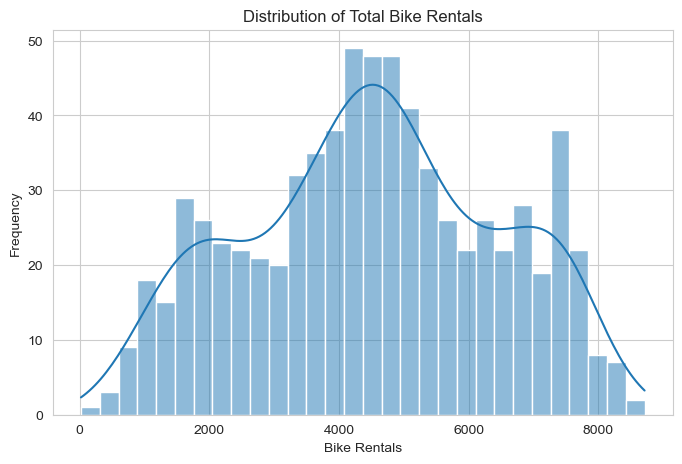

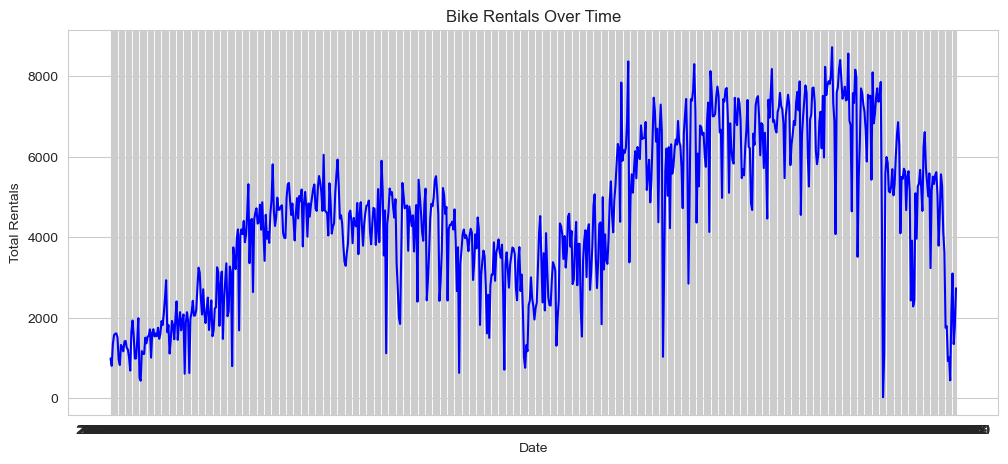

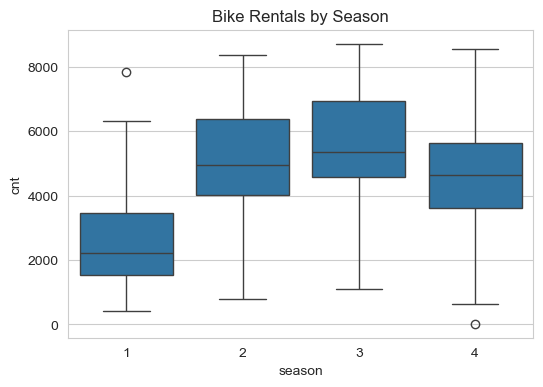

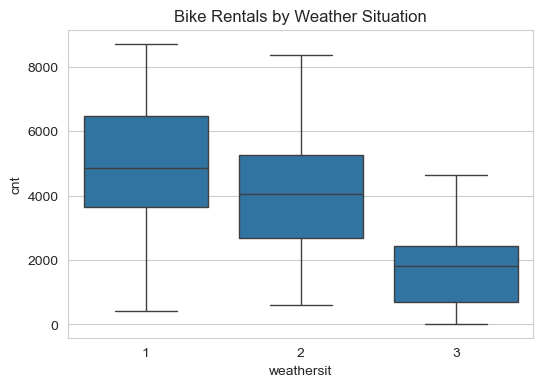

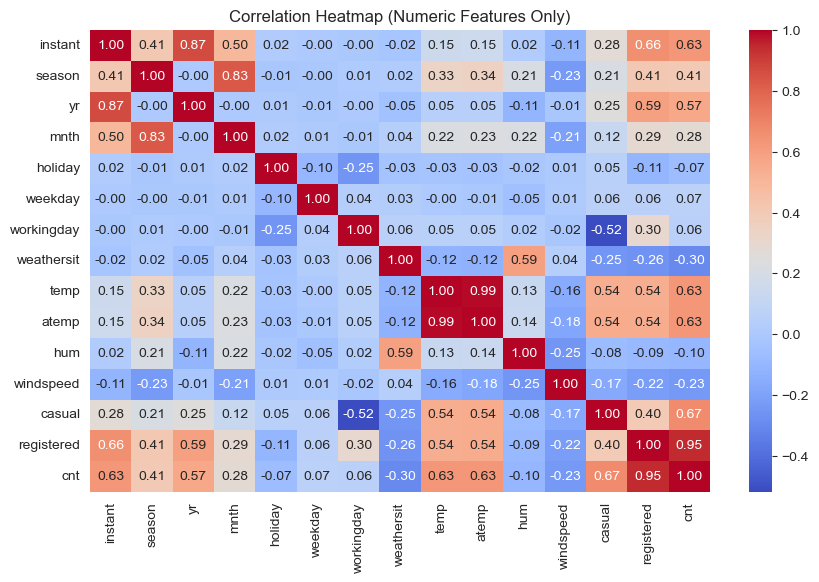

In [28]:
# Step 3: EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics
print("Dataset shape:", train_df.shape)
print("\nSummary statistics:\n", train_df.describe())

# Distribution of target variable (cnt = total rentals)
plt.figure(figsize=(8,5))
sns.histplot(train_df['cnt'], kde=True, bins=30)
plt.title("Distribution of Total Bike Rentals")
plt.xlabel("Bike Rentals")
plt.ylabel("Frequency")
plt.show()

# Rentals over time
plt.figure(figsize=(12,5))
plt.plot(train_df['dteday'], train_df['cnt'], color='blue')
plt.title("Bike Rentals Over Time")
plt.xlabel("Date")
plt.ylabel("Total Rentals")
plt.show()

# Effect of season on rentals
plt.figure(figsize=(6,4))
sns.boxplot(x="season", y="cnt", data=train_df)
plt.title("Bike Rentals by Season")
plt.show()

# Effect of weather situation
plt.figure(figsize=(6,4))
sns.boxplot(x="weathersit", y="cnt", data=train_df)
plt.title("Bike Rentals by Weather Situation")
plt.show()


# Select only numeric columns for correlation
numeric_df = train_df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


In [29]:
# Convert date to datetime
train_df['dteday'] = pd.to_datetime(train_df['dteday'])

# Extract year, month, day, weekday
train_df['year'] = train_df['dteday'].dt.year
train_df['month'] = train_df['dteday'].dt.month
train_df['day'] = train_df['dteday'].dt.day
train_df['weekday'] = train_df['dteday'].dt.weekday


In [30]:
train_df = train_df.drop(['instant', 'dteday'], axis=1)


In [31]:
categorical_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

for col in categorical_cols:
    train_df[col] = train_df[col].astype('category')


In [32]:
X = train_df.drop(['casual', 'registered', 'cnt'], axis=1)  # drop unused targets
y = train_df['cnt']

print("Feature set shape:", X.shape)
print("Target shape:", y.shape)


Feature set shape: (731, 14)
Target shape: (731,)


In [33]:
# Step 5: Model Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,    # number of trees
    max_depth=None,      # let trees expand fully
    random_state=42,
    n_jobs=-1            # use all CPU cores
)

# Train the model
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Random Forest Model Performance")
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


✅ Random Forest Model Performance
Root Mean Squared Error (RMSE): 687.828923932368
R² Score: 0.8820143349481986


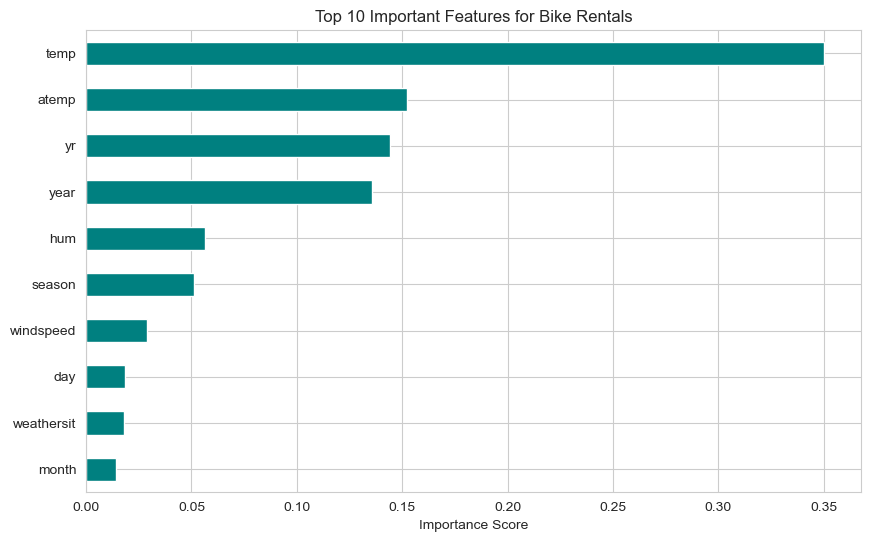

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# Plot top 10
plt.figure(figsize=(10,6))
feat_importances.nlargest(10).sort_values().plot(kind='barh', color="teal")
plt.title("Top 10 Important Features for Bike Rentals")
plt.xlabel("Importance Score")
plt.show()


In [35]:
import joblib

# Save the model
joblib.dump(rf_model, "bike_rental_rf_model.pkl")

# Also save feature columns (important for prediction later)
joblib.dump(list(X.columns), "feature_columns.pkl")

print("✅ Model and feature columns saved successfully!")


✅ Model and feature columns saved successfully!
